In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
with open('/home/xzhou126/ssm/data/tags_rsfMRI_HCP_model_selection', 'rb') as f:
    tags = pickle.load(f)

In [3]:
# 10 folds, 10 subjects each fold
folds = []
for i in range(10):
    folds.append(np.arange(10*i, 10*(i+1), dtype=int))

In [3]:
D_list = [2,3,4,5,6,7,8,9,10]
K_list = [2,3,4,5,6,7,8]

In [ ]:
for D in D_list:
    # only need to load model and q_z
    model = dict()
    elbos = dict()
    q_z = dict()
    for k in range(len(K_list)):
        K = K_list[k]
        model[k] = dict()
        elbos[k] = dict()
        q_z[k] = dict()
        for fold in range(10):
            with open('/home/xzhou126/ssm/model_selection_models/K%s_D%s_model-%s.pkl' %(K, D, fold+1),'rb') as f:
                [model[k][fold], q, elbos[k][fold], q_z[k][fold]] = pickle.load(f)
            del q

    nmi = []
    ari = []
    for k in range(len(K_list)):
        nmi.append([])
        ari.append([])
        for i in range(10):
            for j in range(i+1, 10):
                pid1 = np.unique(model[k][i].tags)
                pid2 = np.unique(model[k][j].tags)
                id_intersect = np.intersect1d(pid1, pid2)
                # rids in each q_z (for common subjects)
                rids1 = np.concatenate([np.where(np.array(model[k][i].tags) == id)[0] for id in id_intersect])
                zs1 = np.concatenate([q_z[k][i][r] for r in rids1])
                rids2 = np.concatenate([np.where(np.array(model[k][j].tags) == id)[0] for id in id_intersect])
                zs2 = np.concatenate([q_z[k][j][r] for r in rids2])
                nmi[k].append(normalized_mutual_info_score(zs1, zs2, average_method = 'arithmetic'))
                ari[k].append(adjusted_rand_score(zs1, zs2))
            
    mean_nmi = np.zeros(len(K_list)) 
    ucb_nmi = np.zeros(len(K_list)) 
    lcb_nmi = np.zeros(len(K_list)) 
    for k in range(len(K_list)):
        mean_nmi[k] = np.mean(nmi[k])
        ucb_nmi[k] = np.quantile(nmi[k],0.95)
        lcb_nmi[k] = np.quantile(nmi[k],0.05)

    mean_ari = np.zeros(len(K_list)) 
    ucb_ari = np.zeros(len(K_list)) 
    lcb_ari = np.zeros(len(K_list)) 
    for k in range(len(K_list)):
        mean_ari[k] = np.mean(ari[k])
        ucb_ari[k] = np.quantile(ari[k],0.95)
        lcb_ari[k] = np.quantile(ari[k],0.05)

    with open('ari/ari_D%s.pkl'%D,'wb') as f:
        pickle.dump([mean_ari, lcb_ari, ucb_ari], f)
    with open('nmi/nmi_D%s.pkl'%D,'wb') as f:
        pickle.dump([mean_nmi, lcb_nmi, ucb_nmi], f)

In [4]:
mean_ari = np.zeros((len(D_list), len(K_list)))
lcb_ari = np.zeros((len(D_list), len(K_list)))
ucb_ari = np.zeros((len(D_list), len(K_list)))
for d in range(len(D_list)):
    with open('ari/ari_D%s.pkl'%(D_list[d]), 'rb') as f:
        [mean_ari[d,:], lcb_ari[d,:], ucb_ari[d,:]] = pickle.load(f)

In [5]:
mean_nmi = np.zeros((len(D_list), len(K_list)))
lcb_nmi = np.zeros((len(D_list), len(K_list)))
ucb_nmi = np.zeros((len(D_list), len(K_list)))
for d in range(len(D_list)):
    with open('nmi/nmi_D%s.pkl'%(D_list[d]), 'rb') as f:
        [mean_nmi[d,:], lcb_nmi[d,:], ucb_nmi[d,:]] = pickle.load(f)

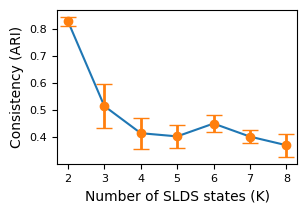

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.1,2))
x = K_list
y = np.mean(mean_ari, axis = 0)
plt.plot(x, y)
err_bar = np.std(mean_ari, axis = 0)
ax.errorbar(x, y, err_bar, fmt='o', linewidth=2, capsize=6)
plt.xlabel('Number of SLDS states (K)', fontsize = 10)
plt.ylabel('Consistency (ARI)', fontsize = 10)
ax.tick_params(axis='y', labelsize=8)   
ax.tick_params(axis='x', labelsize=8)

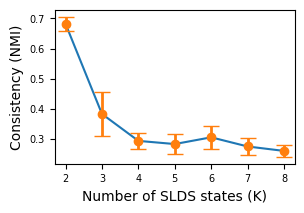

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.1,2))
x = K_list
y = np.mean(mean_nmi, axis = 0)
plt.plot(x, y)
err_bar = np.std(mean_nmi, axis = 0)
ax.errorbar(x, y, err_bar, fmt='o', linewidth=2, capsize=6)
plt.xlabel('Number of SLDS states (K)', fontsize = 10)
plt.ylabel('Consistency (NMI)', fontsize = 10)
ax.tick_params(axis='y', labelsize=7)   
ax.tick_params(axis='x', labelsize=7)

In [ ]:
# # check: NMI between random run pairs
# nmi = []
# for k in range(len(K_list)):
#     nmi.append([])
#     for i in range(10):
#         for j in range(i+1, 10):
#             pid1 = np.unique(model[k][i].tags)
#             pid2 = np.unique(model[k][j].tags)
#             id_intersect = np.intersect1d(pid1, pid2)
#             # rids in each q_z (for common subjects)
#             rids1 = np.concatenate([np.where(np.array(model[k][i].tags) == id)[0] for id in id_intersect])
#             zs1 = np.concatenate([q_z[k][i][r] for r in rids1])
#             rids2 = np.concatenate([np.where(np.array(model[k][j].tags) == id)[0] for id in id_intersect])
#             zs2 = np.concatenate([q_z[k][j][r] for r in rids2])
#             nmi[k].append(normalized_mutual_info_score(zs1, zs2, average_method = 'arithmetic'))

# qz = q_z[4][0]
# nmi_null = []
# for i in range(len(qz)):
#     for j in range(len(qz)):
#         if (j!=i) & (len(qz[i])==len(qz[j])):
#             nmi_null.append(normalized_mutual_info_score(qz[i], qz[j]))

# plt.hist(nmi_null, bins = 30)
# plt.ylabel('num_run_pairs')
# plt.xlabel('NMI')
# #plt.ylabel('density')